**Data Collection and Create CSV file**


In [118]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def download_stock_data(tickers, start_date, end_date=datetime.today().strftime('%Y-%m-%d')):
    # Loop through each ticker and download data
    for ticker in tickers:
        # Download historical data
        data = yf.download(ticker, start=start_date, end=end_date)
        # Reset column names to avoid mismatched headers
        data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
        # Reset the index to a new "Date" column and keep only the date part
        data.reset_index(inplace=True)
        data['Date'] = data['Date'].dt.date  # Convert DateTime to just date (YYYY-MM-DD format) to get rid of hours, minutes, and seconds
        data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime format so model interpre it as dates

        # Save to CSV with Date as a column
        data.to_csv(f'{ticker}_10yrs.csv', index=False)  # Save without the index to make Date a column

**LSTM model Implementation**

**Data Preparation and Scaling**

In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def scale_stock_data(ticker):
    #  Load data and convert 'Date' to datetime format
    data = pd.read_csv(f'{ticker}_10yrs.csv')
    data['Date'] = pd.to_datetime(data['Date'])

    # Use only the 'Close' column for prediction
    close_prices = data[['Close']]

    # Standardize the close prices for better training performance
    scaler = StandardScaler()
    close_prices_scaled = scaler.fit_transform(close_prices)

    return data, close_prices_scaled, scaler

**Sequence Creation**

In [120]:
from sklearn.model_selection import train_test_split

def prepare_data_for_lstm(close_prices_scaled, sequence_length=60):
    # Define sequence length (60 days of historical prices)

    # Create sequences and targets for the model
    X = []
    y = []
    for i in range(sequence_length, len(close_prices_scaled)):
        X.append(close_prices_scaled[i-sequence_length:i])  # Last 30 days
        y.append(close_prices_scaled[i, 0])  # Next day's price

    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)

    # Reshape X to (samples, time steps, features) for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split the data into training and testing sets, remain chronological order
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Show input data details
    print(f"X shape and y shape: {X.shape, y.shape}")
    print(f"X_train shape and y_train shape: {X_train.shape, y_train.shape}")
    print(f"X_test shape and y_test shape: {X_test.shape, y_test.shape}")

    return X_train, X_test, y_train, y_test

**Build and Train Model**

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

def show_model_info(model):
    # Show model summary
    print(model.summary())
    return

def build_and_train_model(X_train, y_train, X_test, y_test, lstm_units, dropout_rate, learning_rate, epochs, batch_size, input_shape):
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit and transform the scaler on the training data
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1]))
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

    # Transform the test data using the fitted scaler
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1]))
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

    # Reshape scaled data back to the original shape for LSTM
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),  # Dropout rate of 20%
        LSTM(lstm_units),
        Dropout(dropout_rate),
        Dense(1)
    ])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)  # Adjust learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model with verbose set to 0 to suppress epoch output
    history = model.fit(
        X_train_scaled, y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test_scaled),
        verbose=0
    )

    # Predict on test data
    y_pred_scaled = model.predict(X_test_scaled)

    # Reverse the standardization to get predictions in original scale
    y_test_unscaled = scaler.inverse_transform(y_test_scaled).flatten()
    y_pred_unscaled = scaler.inverse_transform(y_pred_scaled).flatten()

    return model, history, y_pred_unscaled, y_test_unscaled


**Prepare for Incremental Learning**

In [122]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def get_new_data(ticker, scaler, sequence_length=60):
    # scaler = StandardScaler()
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=90)).strftime('%Y-%m-%d')

    data = yf.download(ticker, start=start_date, end=end_date)
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

    # Convert to DataFrame to preserve feature names
    close_prices_df = pd.DataFrame(data['Close'])

    # Scale and fit data
    close_prices_scaled = scaler.fit_transform(close_prices_df)
    X_new = []
    y_new = []
    for i in range(sequence_length, len(close_prices_scaled)):
        X_new.append(close_prices_scaled[i-sequence_length:i])
        y_new.append(close_prices_scaled[i, 0])  # Next day's price

    # Convert to numpy arrays
    X_new, y_new = np.array(X_new), np.array(y_new)
    y_new = y_new.reshape(-1, 1)

    return X_new, y_new


**Incremental Learning**

In [123]:
def incremental_learning_process(ticker, model, scaler, iterations=10):
    for epoch in range(1, iterations + 1):
        X_new, y_new = get_new_data(ticker, scaler)

        # Reshape for model input
        X_new_reshaped = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)

        # Train the model with verbose=0 to silence epoch printing
        model.fit(X_new_reshaped, y_new, epochs=5, batch_size=64, verbose=0)

        # Predict on the new data
        y_pred_scaled = model.predict(X_new_reshaped)

        # Inverse transform to get original scale
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled).flatten()

        # Optionally print a summary for each update
        print(f'Update {epoch}: predicted price:', y_pred_unscaled)

    return model

**Metrics Evaluation**

In [124]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error

def evaluate_model_performance(ticker, y_test_unscaled, y_pred_unscaled):
    # RMSE (Root Mean Square Error)
    print(f'For {ticker}:')
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    print(f"RMSE: {rmse}")

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    print(f"MAE: {mae}")

    # Direction Accuracy
    direction_accuracy = np.mean(
        np.sign(y_test_unscaled[1:] - y_test_unscaled[:-1]) == np.sign(y_pred_unscaled[1:] - y_test_unscaled[:-1])
    ) * 100
    print(f"Direction Accuracy: {direction_accuracy:.2f}%")

    # Backtesting
    # Simulate trading: Buy if price is predicted to go up, sell if it goes down
    returns = (y_test_unscaled[1:] - y_test_unscaled[:-1])  # Actual price changes
    predicted_returns = (y_pred_unscaled[1:] - y_test_unscaled[:-1])  # Predicted price changes
    profit = np.sum(np.sign(predicted_returns) * returns)

    print(f"Backtesting Profit: ${profit:.2f}")

**Plot**


In [125]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_actual_vs_predicted(data, y_test_unscaled, y_pred_unscaled, ticker):
    # Plot the actual vs. predicted values on test data
    plt.figure(figsize=(10, 6))

    # Plotting only the test range
    plt.plot(data['Date'][-len(y_test_unscaled):], y_test_unscaled, label='Actual Closing Price', color='blue')
    plt.plot(data['Date'][-len(y_test_unscaled):], y_pred_unscaled, label='Predicted Closing Price', color='green')

    plt.xlabel('Date')
    plt.ylabel('Closing Price reverse z-score normalization')
    plt.title(f"Actual vs Predicted Closing Prices of {ticker} (2 Years)")
    plt.legend()

    # Set date format on x-axis (adapted for 10-year range)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Tick every year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

**Main Function**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_76 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_77 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [248.75923 248.91548 249.15903]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [248.30307 248.38599 248.51912]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [245.04398 245.0339  245.06757]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [250.56053 250.61479 250.67865]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [244.34738 244.37012 244.41005]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [249.68956 249.7102  249.75941]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [247.66241 247.6799  247.71219]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [246.69157 246.71796 246.74185]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [247.04231 247.0752  247.09813]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Update 10: predicted price: [247.24562 247.28706 247.31096]
For AAPL:
RMSE: 0.19476594618032256
MAE: 0.1425323728742993
Direction Accuracy: 44.84%
Backtesting Profit: $-1.78


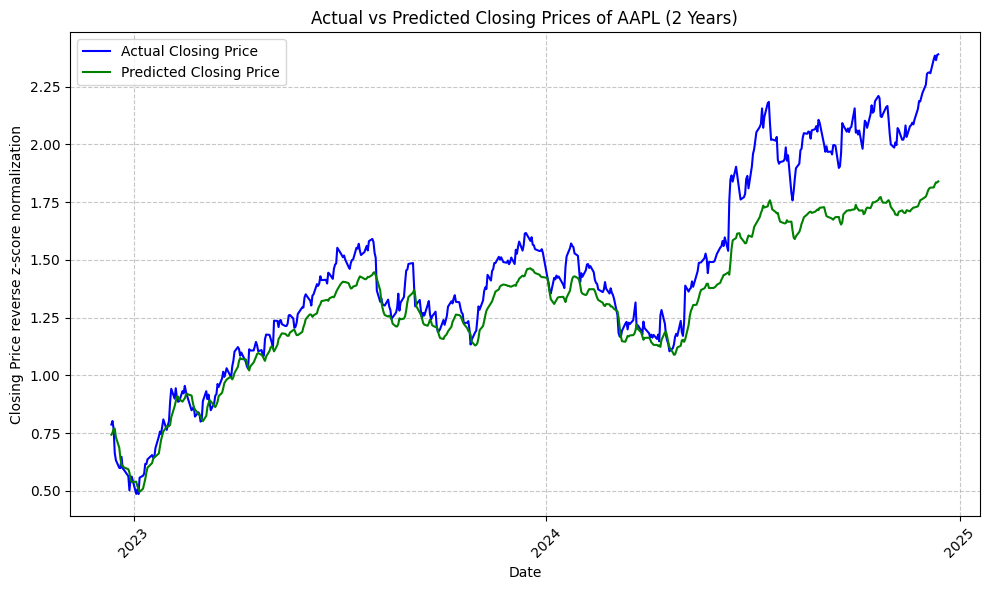

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_79 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [137.28711 136.4091  135.89464]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [139.89656 137.081   135.06465]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [138.46748 135.2479  133.03996]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [139.39684 137.66463 136.12416]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [138.5049  136.3105  134.50604]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [140.4377  137.25182 134.43082]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [139.29538 136.75407 134.51823]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [138.92754 136.6635  134.65022]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [140.29951 137.34174 134.59099]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Update 10: predicted price: [139.2417  136.52481 134.11171]
For NVDA:
RMSE: 1.4423630781885988
MAE: 0.9964401729416889
Direction Accuracy: 44.05%
Backtesting Profit: $-3.68


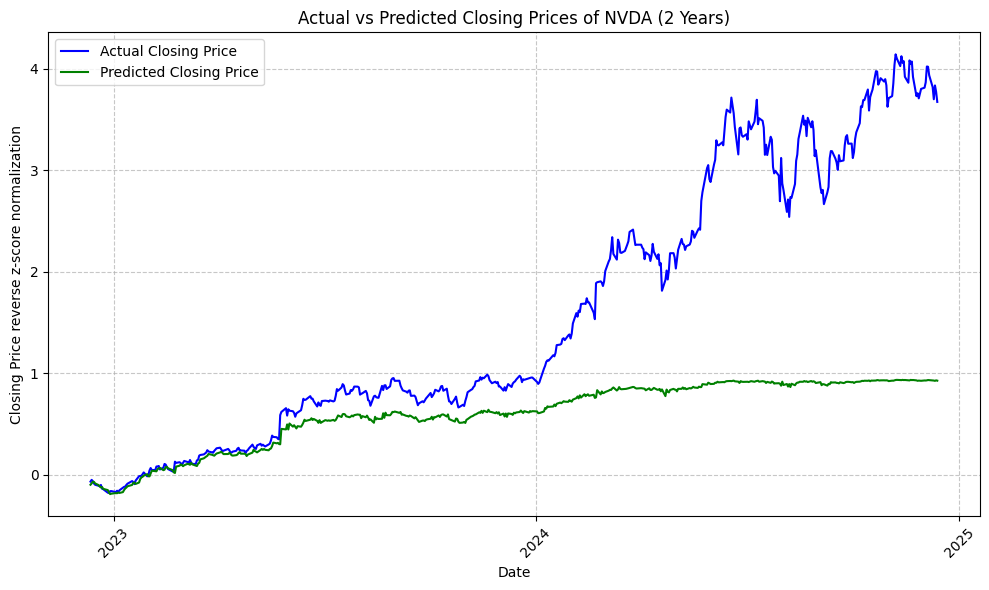

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_81 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [446.95227 448.13696 448.74915]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [441.6636  441.77374 441.70117]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [450.4241  450.7908  450.94714]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [447.224   447.34076 447.36383]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [447.6718  447.75674 447.75714]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [450.1696  450.2616  450.25128]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [445.95886 445.97604 445.96857]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [446.28104 446.28082 446.27255]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [449.67392 449.69528 449.6791 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Update 10: predicted price: [449.14508 449.17288 449.15375]
For MSFT:
RMSE: 0.2801239069628503
MAE: 0.2397592141342927
Direction Accuracy: 45.44%
Backtesting Profit: $-1.59


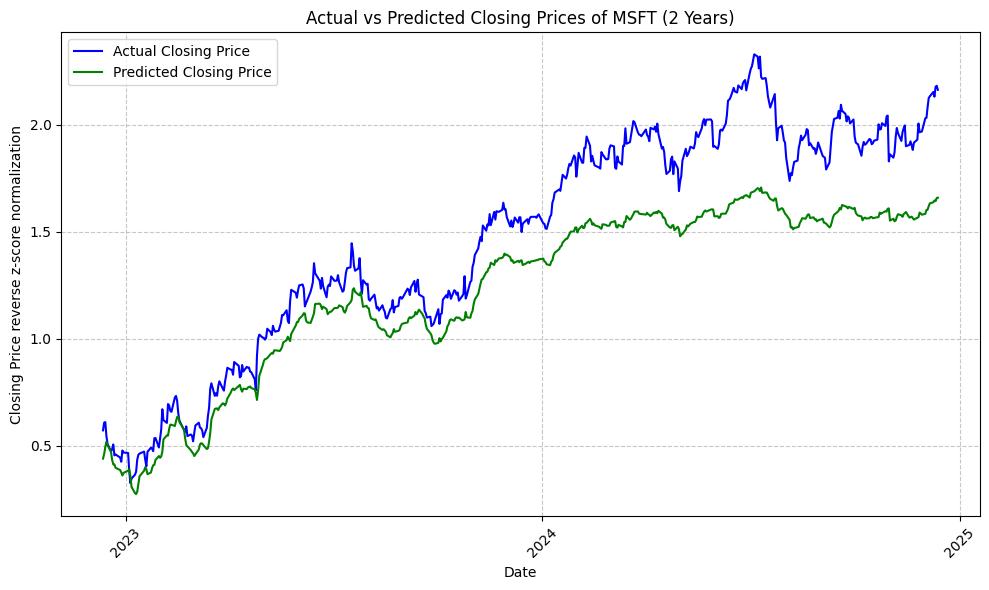

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_83 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [224.28847 225.2349  225.49205]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [237.087   237.36961 237.50407]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [222.73907 222.74872 222.74516]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [233.60878 233.72232 233.76149]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [225.44804 225.46487 225.47078]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [226.3969  226.40683 226.41467]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [234.25406 234.2812  234.28804]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [226.48279 226.48976 226.4953 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [225.84201 225.83875 225.84192]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Update 10: predicted price: [229.76567 229.76208 229.76193]
For AMZN:
RMSE: 0.15017738973959877
MAE: 0.11959791305829347
Direction Accuracy: 45.63%
Backtesting Profit: $-2.77


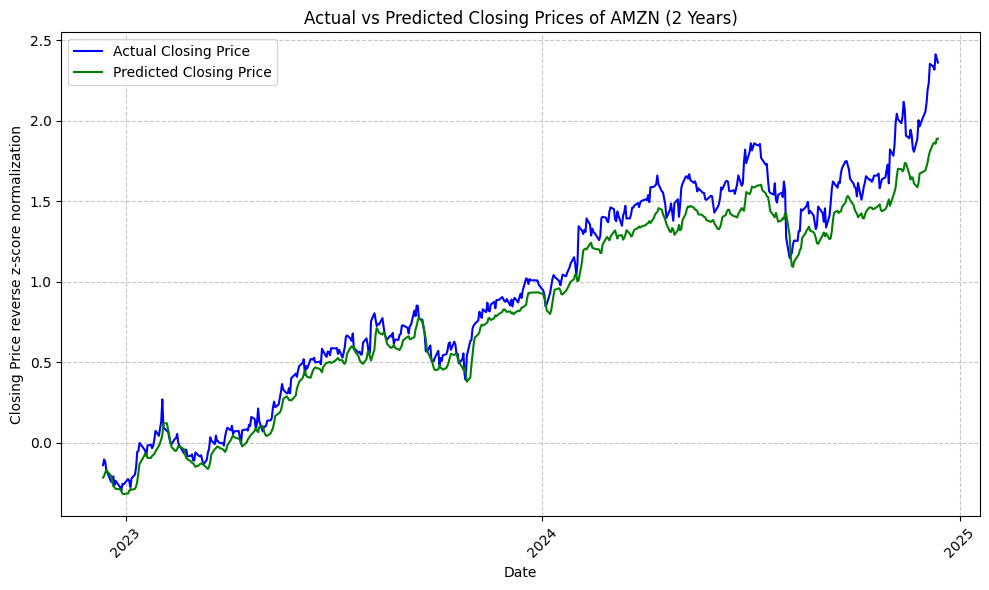

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [196.2093  196.91183 195.56854]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [194.53712 193.41226 191.90755]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [196.1295  195.02896 194.40521]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [191.15161 189.66661 189.28912]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [197.56503 195.30405 195.14403]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [196.08173 194.07248 193.17484]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [195.38156 192.48299 190.5859 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [198.97552 194.4799  190.78783]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [196.10936 193.39616 188.42587]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Update 10: predicted price: [192.99725 191.40396 188.62613]
For GOOG:
RMSE: 0.3490067208883618
MAE: 0.2750839632470386
Direction Accuracy: 42.66%
Backtesting Profit: $-2.45


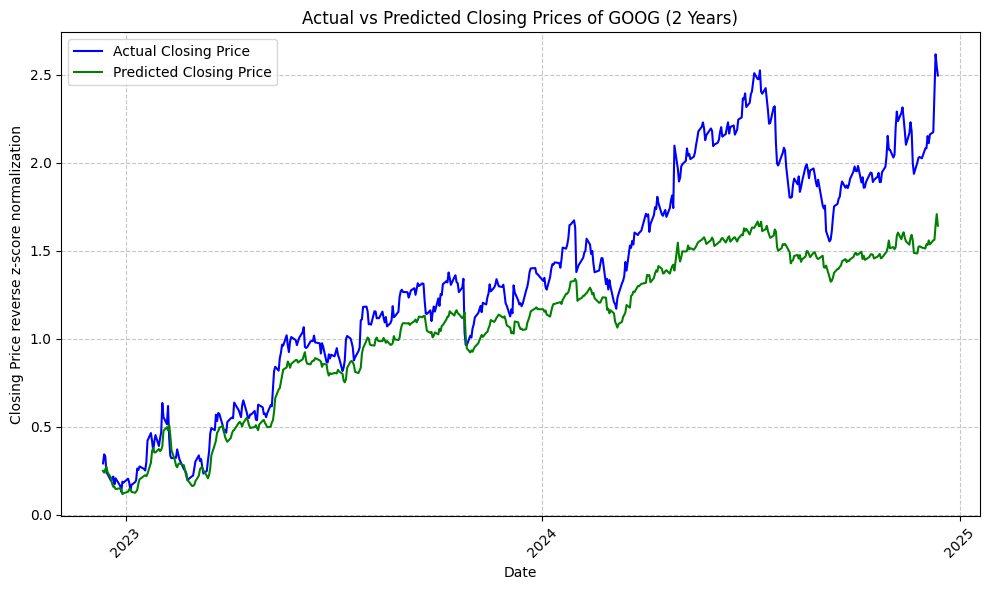

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((1191, 60, 1), (1191,))
X_train shape and y_train shape: ((952, 60, 1), (952,))
X_test shape and y_test shape: ((239, 60, 1), (239,))
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_86 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_87 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [28.41149  28.331205 28.315145]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [28.363195 28.33002  28.318598]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [28.499735 28.45202  28.429644]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [28.465452 28.359785 28.342115]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [28.530535 28.485485 28.497517]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [28.509598 28.494015 28.51041 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [28.333668 28.323723 28.332014]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [28.593435 28.590017 28.599524]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [28.3578   28.353241 28.360292]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Update 10: predicted price: [28.464926 28.45868  28.466843]
For 2222.SR:
RMSE: 0.09853606769764556
MAE: 0.07522028995329563
Direction Accuracy: 44.54%
Backtesting Profit: $1.21


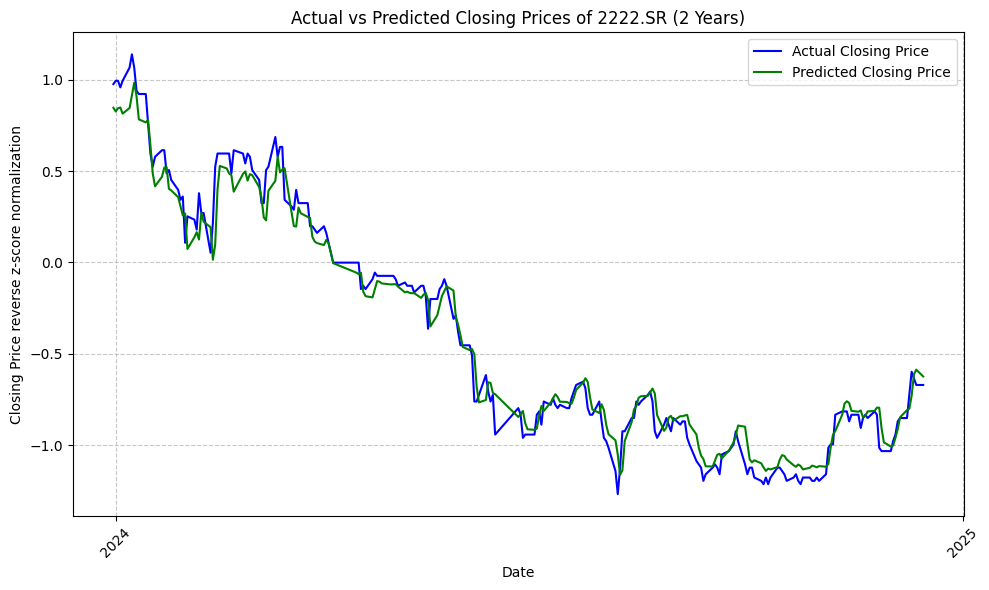

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_89 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [623.7697  625.76306 624.04816]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [638.8462  631.57874 635.27844]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [614.883   614.37775 613.4202 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [634.5659 633.6087 632.9629]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [626.3056 624.9978 623.8484]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [638.8125  636.42267 635.3204 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [624.2444 622.1624 621.2412]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [626.16956 624.2638  622.6369 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [638.20776 634.1828  630.2884 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Update 10: predicted price: [627.3216  625.2668  618.34906]
For META:
RMSE: 0.44504195862679125
MAE: 0.2914754469205671
Direction Accuracy: 49.60%
Backtesting Profit: $0.17


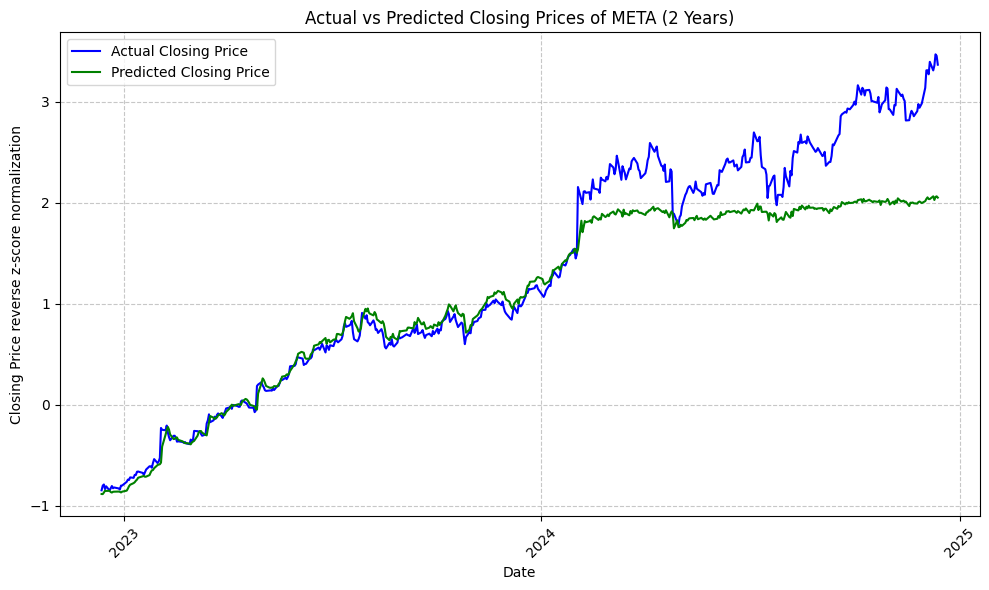

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_91 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [401.68558 415.9721  415.32404]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [418.35052 426.19635 424.46802]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [415.81067 421.01633 419.65128]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [439.1059 443.7725 443.641 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [394.1465  396.7248  396.74884]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [433.14563 435.11813 435.67285]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [402.5781  403.68854 404.141  ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [437.31   438.1642 438.6754]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [411.46304 411.96445 412.48334]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Update 10: predicted price: [427.0209  427.35925 428.01352]
For TSLA:
RMSE: 0.09403564574009261
MAE: 0.07223322562316055
Direction Accuracy: 52.58%
Backtesting Profit: $1.39


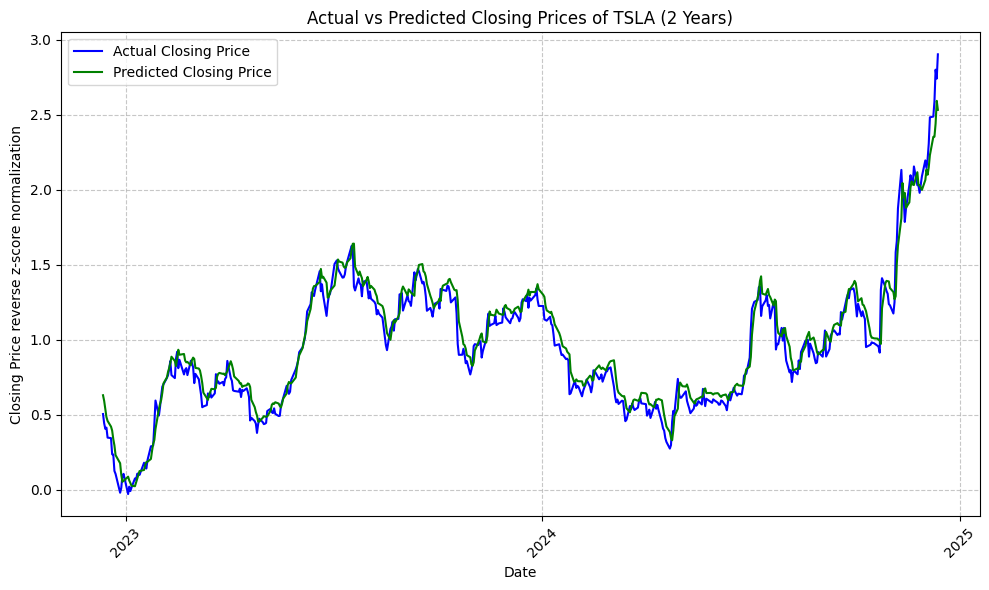

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_92 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_93 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [196.8812  196.96158 196.51149]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [194.77817 195.17862 195.17471]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [193.84624 194.1984  194.56262]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [193.66402 193.7375  194.81956]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [192.77608 191.20653 196.43443]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [193.6074  190.63484 200.33899]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [194.19778 192.34935 199.62915]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [194.66199 192.09033 200.832  ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [196.21706 191.12442 199.95486]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Update 10: predicted price: [194.25153 191.3278  202.0496 ]
For TSM:
RMSE: 0.43984391509317017
MAE: 0.2679044016732882
Direction Accuracy: 48.02%
Backtesting Profit: $-1.93


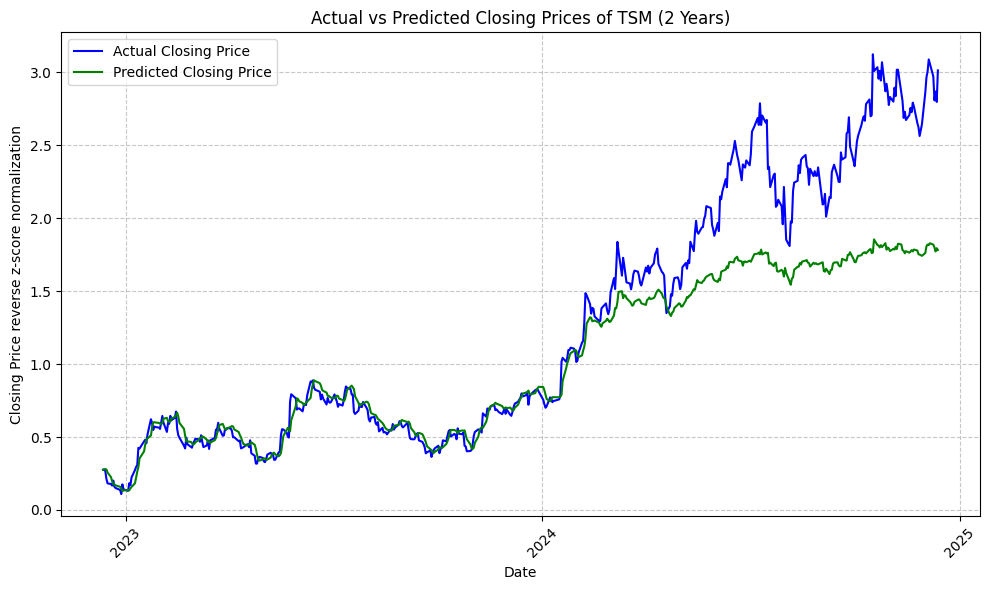

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


X shape and y shape: ((2523, 60, 1), (2523,))
X_train shape and y_train shape: ((2018, 60, 1), (2018,))
X_test shape and y_test shape: ((505, 60, 1), (505,))
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_95 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

[*********************100%***********************]  1 of 1 completed

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 1: predicted price: [182.44421 182.3257  181.5801 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 2: predicted price: [193.83644 197.03677 197.26337]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed

Update 3: predicted price: [194.12581 195.90817 197.29495]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[*********************100%***********************]  1 of 1 completed

Update 4: predicted price: [190.08287 191.61086 195.8889 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[*********************100%***********************]  1 of 1 completed

Update 5: predicted price: [184.37106 201.27919 218.78915]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[*********************100%***********************]  1 of 1 completed

Update 6: predicted price: [179.39467 182.3002  224.64952]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


[*********************100%***********************]  1 of 1 completed

Update 7: predicted price: [181.73048 180.436   231.98889]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


[*********************100%***********************]  1 of 1 completed

Update 8: predicted price: [186.89583 178.16446 225.57349]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


[*********************100%***********************]  1 of 1 completed

Update 9: predicted price: [183.90533 173.37564 223.51161]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Update 10: predicted price: [179.96364 181.3066  229.05391]
For AVGO:
RMSE: 1.112441275688746
MAE: 0.8365481756280723
Direction Accuracy: 47.42%
Backtesting Profit: $-4.28


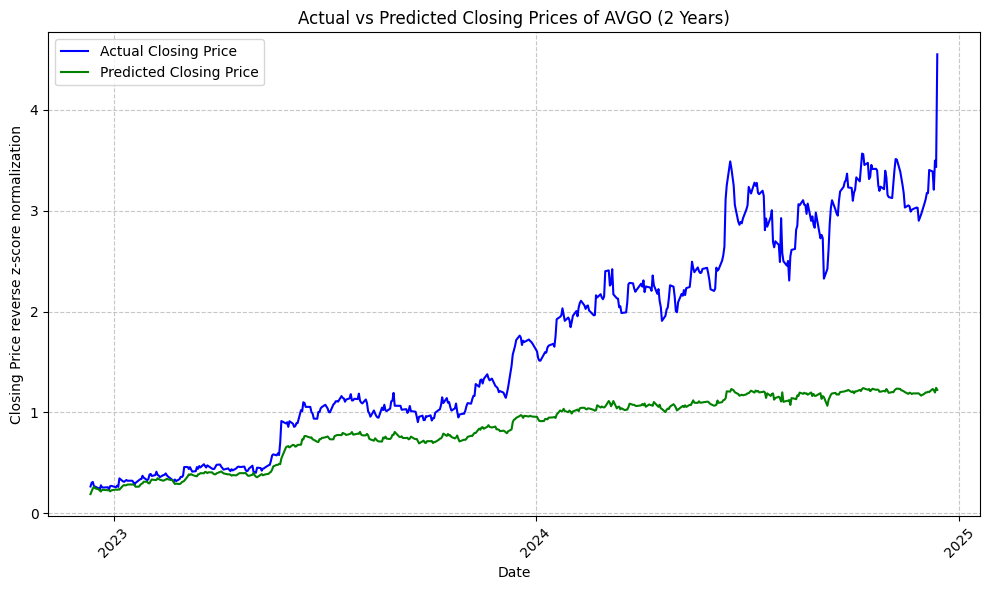

In [126]:
# Define tickers and start date, end date is default today
# tickers = ['AAPL']
tickers = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOG', '2222.SR', 'META', 'TSLA', 'TSM', 'AVGO']

start_date = '2014-9-11'
lstm_units = 50
dropout_rate=0.2
learning_rate=0.01
epochs=20
batch_size=64
sequence_length=60 # Sequence length is consistent with the input shape
input_shape=(60, 1)

def lstm_model(ticker, start_date, lstm_units, dropout_rate, learning_rate, epochs, batch_size, input_shape):
    # Download the data from yfinace
    download_stock_data(tickers, start_date)
    # print(data.tail())
    # print(data.head())

    # Scale data
    data, close_prices_scaled, scaler = scale_stock_data(ticker)

    # Create sequence for lstm
    X_train, X_test, y_train, y_test = prepare_data_for_lstm(close_prices_scaled, sequence_length)

    # Define and build the model
    model, history, y_pred_unscaled, y_test_unscaled = build_and_train_model(X_train, y_train, X_test, y_test, lstm_units, dropout_rate, learning_rate, epochs, batch_size, input_shape)

    # Show model information
    show_model_info(model)

    # Incremental Learning
    updated_model = incremental_learning_process(ticker, model, scaler)


    # Evaluate model
    evaluate_model_performance(ticker, y_test_unscaled, y_pred_unscaled)

    # Plot the model
    plot_actual_vs_predicted(data, y_test_unscaled, y_pred_unscaled, ticker)
    return

for ticker in tickers:
    lstm_model(ticker, start_date, lstm_units, dropout_rate, learning_rate, epochs, batch_size, input_shape)
